In [1]:
import warnings
import numpy as np
import pandas as pd
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

**Contexto dos Dados**

- Base Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
- Telco é uma companhia que provê telefone e internet residencial
- Conteúdo: Cada linha representa um consumidor, cada coluna contém um atributito deste cliente na empresa

In [2]:
df = pd.read_csv("../Dados/telco_dataset.csv")
df.drop(['customerID'],axis=1, inplace=True)

## Pré-processamento

### 1. Tratamento dos Dados

In [3]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0)

In [4]:
num = ["tenure", "MonthlyCharges", "TotalCharges"]
categ = ['OnlineSecurity','TechSupport']

In [5]:
df_reduced = df[num+categ+["Churn"]]
df_reduced.head()

,tenure,MonthlyCharges,TotalCharges,OnlineSecurity,TechSupport,Churn
0,1,29.85,29.85,No,No,No
1,34,56.95,1889.5,Yes,No,No
2,2,53.85,108.15,Yes,No,Yes
3,45,42.30,1840.75,Yes,Yes,No
4,2,70.70,151.65,No,No,Yes


In [6]:
for col in num:
    try:df_reduced[col] = df_reduced[col].astype("float")
    except:print(col)

/var/folders/bw/v83lk_712p9f1shyv5wxd2vr0000gp/T/ipykernel_15405/4155709564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  try:df_reduced[col] = df_reduced[col].astype("float")
/var/folders/bw/v83lk_712p9f1shyv5wxd2vr0000gp/T/ipykernel_15405/4155709564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  try:df_reduced[col] = df_reduced[col].astype("float")
/var/folders/bw/v83lk_712p9f1shyv5wxd2vr0000gp/T/ipykernel_15405/4155709564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [7]:
for col in categ:
    try:
        df_reduced[col] = df_reduced[col].astype("str")
        df_reduced[col] = df_reduced[col].str.strip()
    except:
        print(col)

/var/folders/bw/v83lk_712p9f1shyv5wxd2vr0000gp/T/ipykernel_15405/3490255306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[col] = df_reduced[col].astype("str")
/var/folders/bw/v83lk_712p9f1shyv5wxd2vr0000gp/T/ipykernel_15405/3490255306.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[col] = df_reduced[col].str.strip()
/var/folders/bw/v83lk_712p9f1shyv5wxd2vr0000gp/T/ipykernel_15405/3490255306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

### 2. Transformação dos Dados

In [8]:
categorical_cols = [c for c in df_reduced.columns if df_reduced[c].dtype == 'object']
df_categorical = df_reduced[categorical_cols].copy()
for col in categorical_cols:
    if df_categorical[col].nunique() == 2:
        df_categorical[col], _ = pd.factorize(df_categorical[col])
    else:
        df_categorical = pd.get_dummies(df_categorical, columns=[col])

In [9]:
df_categorical.columns

Index(['Churn', 'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes'],
      dtype='object')

In [10]:
scaler = StandardScaler().fit(df_reduced[num]) 
df_std = pd.DataFrame(scaler.transform(df_reduced[num]), columns=num)

In [11]:
df_processed = pd.concat([df_std, df_categorical], axis=1)
df_processed.head()

,tenure,MonthlyCharges,TotalCharges,Churn,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes
0,-1.277445,-1.160323,-0.992611,0,True,False,False,True,False,False
1,0.066327,-0.259629,-0.172165,0,False,False,True,True,False,False
2,-1.236724,-0.362660,-0.958066,1,False,False,True,True,False,False
3,0.514251,-0.746535,-0.193672,0,False,False,True,False,False,True
4,-1.236724,0.197365,-0.938874,1,True,False,False,True,False,False


In [12]:
df_no = df_processed[df_processed["Churn"]==0].sample(n=len(df_processed[df_processed["Churn"]==1]))
df_yes = df_processed[df_processed["Churn"]==1]
df_balanced = pd.concat([df_no, df_yes])

In [13]:
df_balanced['charges_ratio'] = df_balanced['tenure']*df_balanced['MonthlyCharges'] / (df_balanced['TotalCharges'] + 1)

In [14]:
df_balanced.shape

(3738, 11)

## Contruindo o modelo

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [16]:
train, test = train_test_split(df_balanced, test_size=0.2, random_state=50)
predictors = [c for c in train.columns if c not in ['customerID', 'Churn']]

In [17]:
predictors

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'charges_ratio']

In [18]:
test.head()

,tenure,MonthlyCharges,TotalCharges,Churn,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,charges_ratio
6385,-1.155283,1.227679,-0.844947,1,True,False,False,True,False,False,-9.147286
2285,0.840014,0.968439,1.213017,1,False,False,True,True,False,False,0.367599
863,-1.196004,1.008322,-0.870160,1,True,False,False,True,False,False,-9.288040
1064,-0.748080,-0.301174,-0.654973,0,False,False,True,False,False,True,0.652999
1005,0.840014,1.033249,1.207304,0,True,False,False,True,False,False,0.393215


In [19]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(train[predictors], train['Churn'])
y_pred_tree = clf_tree.predict(test[predictors])
print(accuracy_score(test['Churn'], y_pred_tree))

0.6631016042780749


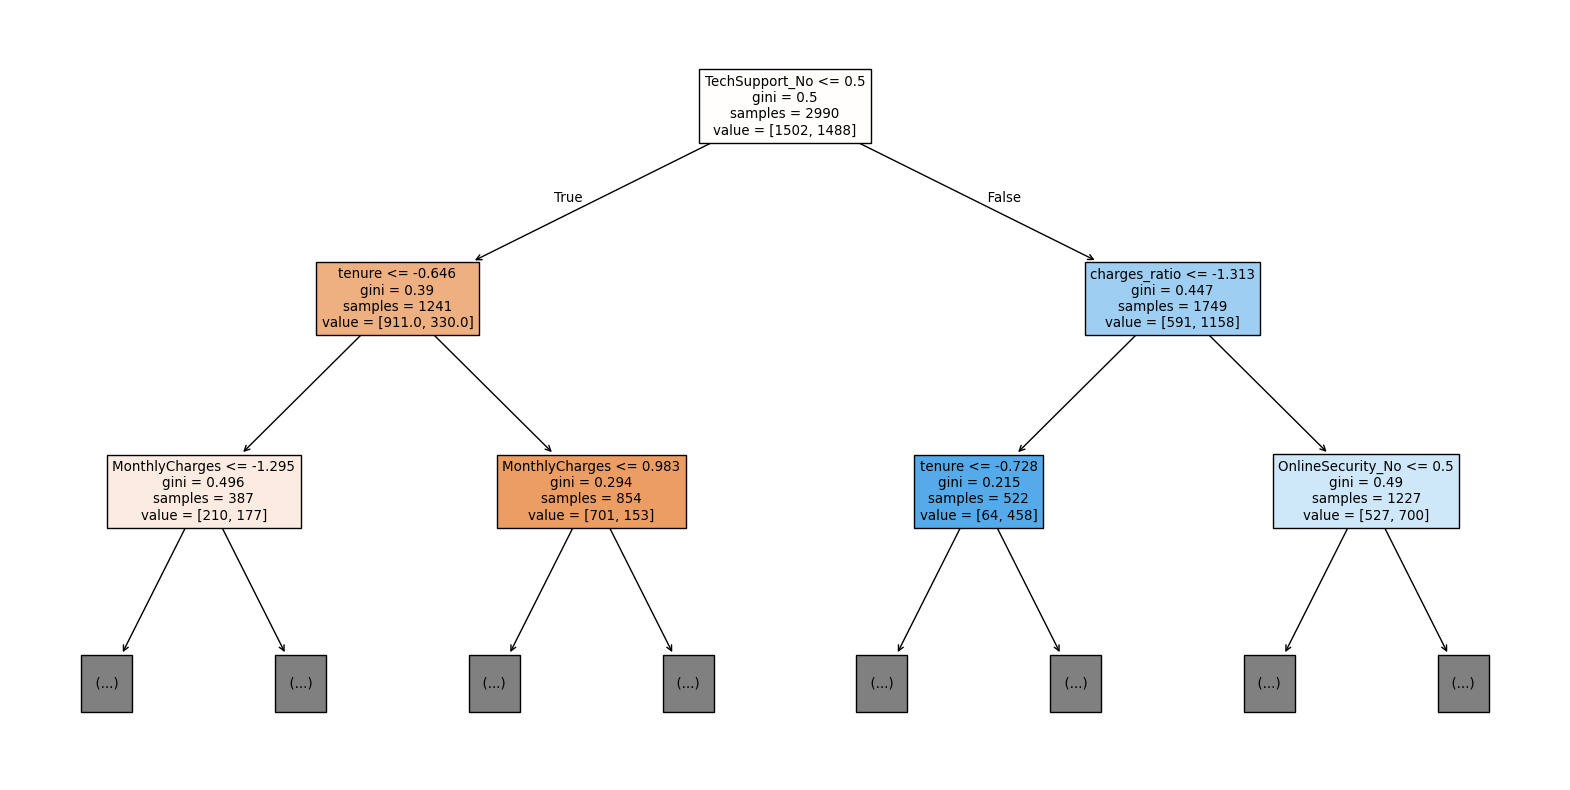

In [20]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(clf_tree, 
                   max_depth = 2,
                   feature_names=predictors,  
                   filled=True)

In [21]:
import pickle

In [22]:
pickle.dump(clf_tree, open("churn_tree_model.pkl", 'wb'))

In [23]:
pickle.dump(scaler, open("scaler.pkl", 'wb'))